<h3>CMM Sample Data Crustal Thickness Analysis II - Method, Results, and Interpretation</h3>

__Notebook Initial Creation:__ 1/23/2017 <br>
__Author:__ pjparis

__This notebook continues the thread developed in notebook: CMM Sample Data (20k pnts) Crustal Thickness Analysis__

We're still looking for the OCT

<h4>Initial Data Load:</h4>

In [7]:
fpath='/Users/paulp/GoogleDrive/projects/ContinentalMarginMapping/data/GCS_EDA_sampling/'
file='CMM_20krandompnts.csv'

df = pd.read_csv(fpath+file, names=['ID','CrustThk','Elevation','Magnetic','Gravity','gForms','Lon','Lat'], skiprows=1).dropna()

<h4>Data Preprocessing:</h4>

In [10]:
# import the Matplotlib plotting handlers:
from matplotlib import pyplot as plt

%matplotlib inline

# Render crustal thickness as positive values. Prior were all measured as
# distances from the sea bed to base of crust (Moho) so < 0:
df.CrustThk = df.CrustThk* -1

# build the arrays needed for the Natural Breaks from the df:
X = df.ix[:,1:5]                # extract the continuous numeric fields in df
y = np.array(df.ix[:,5] )       # extract the geomorphon type classifier field only


<h4>The Fisher-Jenks Natural Breaks Optimization Routines - Part A: the Callable Functions</h4>

In [4]:
import random
from pysal.esda.mapclassify import Natural_Breaks as nb
import time

def ComputeNaturalBreaks(pc_array, klasses):
    '''
    partitions data into classes using PySAL pysal.esda.mapclassify, Natural_Breaks algorithm. 
    input: array of values to classify
    returns: upper bounds for classes
    '''
    breaks=nb(pc_array, k=klasses, initial=20)
    return(breaks)


def goodness_of_variance_fit(array, classes):
    # get the break points
    #classes = jenks(array, classes)

    # do the actual classification - assign values based on class breaks
    classified = np.array([classify(i, classes) for i in array])

    # max value of zones
    maxz = max(classified)

    # nested list of zone indices
    zone_indices = [[idx for idx, val in enumerate(classified) if zone + 1 == val] for zone in range(maxz)]

    # sum of squared deviations from array mean
    sdam = np.sum((array - array.mean()) ** 2)

    # sorted polygon stats
    array_sort = [np.array([array[index] for index in zone]) for zone in zone_indices]

    # sum of squared deviations of class means
    sdcm = sum([np.sum((classified - classified.mean()) ** 2) for classified in array_sort])

    # goodness of variance fit
    gvf = (sdam - sdcm) / sdam

    return gvf


def classify(value, breaks):
    for i in range(1, len(breaks)):
        if value < breaks[i]:
            return i
    return len(breaks) - 1

# ##
# ## Call ComputeClusterBndys with data to generate class break cluster boundarys...  <--------- call this guy
# ##
def ComputeClusterBndys(data_array, num_classes, gvf_threshold):
    start_time = time.time()

    pc_array = np.array(data_array)    # extract the crustal thickness column from the df
    breaksList=[]

    klasses=num_classes
    gvf = 0.0
    gvf_acceptance=gvf_threshold
    
    # compute F-J natural breaks and goodness of fit:
    while(gvf < gvf_acceptance):
        print('Trying', klasses, 'class breaks...')
        # classify data using PySAL Natural Breaks Lib.
        breaks=ComputeNaturalBreaks(pc_array, klasses)

        # compute goodness of variance fit
        gvf = goodness_of_variance_fit(pc_array, breaks.bins)   #(data, nclasses)
        klasses+=1
    
    breaksList.append(breaks.bins) 
    
    return(breaksList)

print('N-B Functions Loaded...')

N-B Functions Loaded...


<h4>Continued Exploratory Analysis of Crustal Thickness:</h4>

1. Partition the full sample data set into observations emergent (elevation >= 0) and submergent (elevation < 0)
2. Plot the overall crustal thickness data vs. elevation, then...
3. Plot the emergent and submergent crustal thickness data vs. elevation


In [14]:
# extract all records from the df where elevation < 0:
df_wet = df.query('Elevation < 0.0')

# extract all records from the df where elevation >= 0:
df_dry = df.query('Elevation >= 0.0')

__Crustal thickness vs. gravity and elevation (all sample observations)__

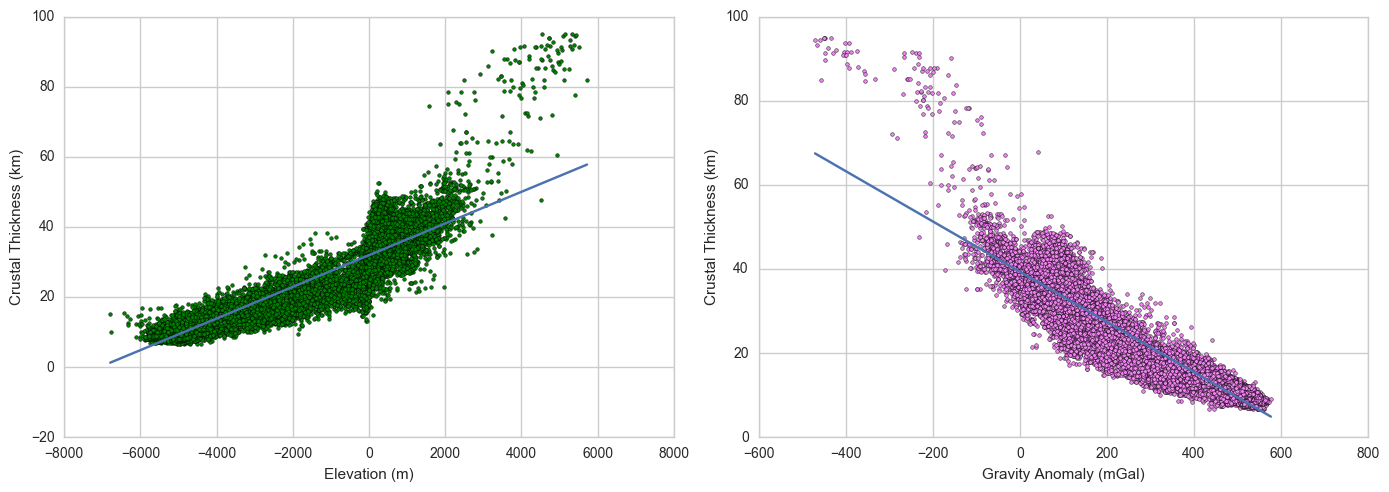

In [12]:
fig1 = plt.figure(figsize=(14,5))
with plt.style.context('seaborn-whitegrid'):
    ax1 = fig1.add_subplot(1,2,1)
    ax1.scatter(df.Elevation, df.CrustThk, s=7, c='green', label='')
    ax1.set_xlabel('Elevation (m)')
    ax1.set_ylabel('Crustal Thickness (km)')
    # adding a best fit (regression) line:
    ax1.plot(np.unique(df.Elevation), np.poly1d(np.polyfit(df.Elevation, df.CrustThk, 1))(np.unique(df.Elevation)))
    
    ax1 = fig1.add_subplot(1,2,2)
    ax1.scatter(df.Gravity, df.CrustThk, s=7, c='violet', label='')
    ax1.set_xlabel('Gravity Anomaly (mGal)')
    ax1.set_ylabel('Crustal Thickness (km)')
    # adding a best fit (regression) line:
    ax1.plot(np.unique(df.Gravity), np.poly1d(np.polyfit(df.Gravity, df.CrustThk, 1))(np.unique(df.Gravity)))
    
    plt.tight_layout()
    plt.show()

Interesting symmetry between elevation and gravity vs. crust thickness. Shouldn't be surprised though for gravity fields (anomalies) were the primary source in the generation of the crustal thickness data.

The straight line fits appear to be only reasonable for the lower half of each data set. For crust thicknesses greater than about 35 km the fit overall fit is quite poor. A curvilinear (polynomial) fit would be a better model...

...unless, perhaps, we subset the data!

Let's look at the data parsed into emergent and submergent parts:

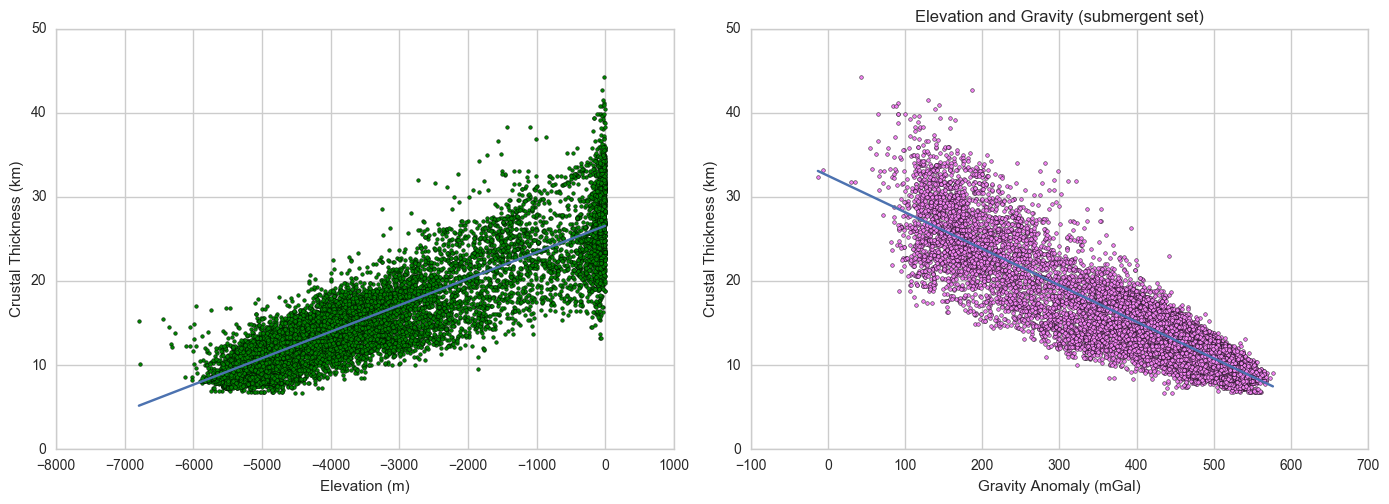

In [17]:
### submergent

fig2 = plt.figure(figsize=(14,5))
with plt.style.context('seaborn-whitegrid'):
    ax2 = fig2.add_subplot(1,2,1)
    ax2.scatter(df_wet.Elevation, df_wet.CrustThk, s=7, c='green', label='')
    ax2.set_xlabel('Elevation (m)')
    ax2.set_ylabel('Crustal Thickness (km)')
    # adding a best fit (regression) line:
    ax2.plot(np.unique(df_wet.Elevation), np.poly1d(np.polyfit(df_wet.Elevation, df_wet.CrustThk, 1))(np.unique(df_wet.Elevation)))
    
    ax2 = fig2.add_subplot(1,2,2)
    ax2.scatter(df_wet.Gravity, df_wet.CrustThk, s=7, c='violet', label='')
    ax2.set_xlabel('Gravity Anomaly (mGal)')
    ax2.set_ylabel('Crustal Thickness (km)')
    # adding a best fit (regression) line:
    ax2.plot(np.unique(df_wet.Gravity), np.poly1d(np.polyfit(df_wet.Gravity, df_wet.CrustThk, 1))(np.unique(df_wet.Gravity)))
    
    plt.tight_layout()
    plt.title('Elevation and Gravity (submergent set)')
    plt.show()

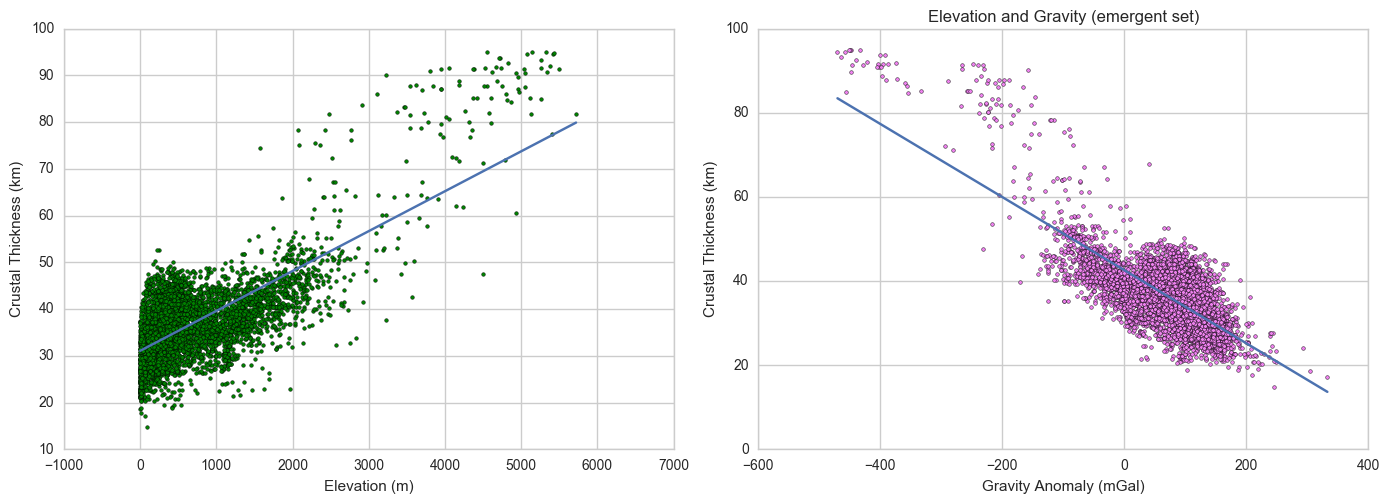

In [18]:
### emergent

fig3 = plt.figure(figsize=(14,5))
with plt.style.context('seaborn-whitegrid'):
    ax3 = fig3.add_subplot(1,2,1)
    ax3.scatter(df_dry.Elevation, df_dry.CrustThk, s=7, c='green', label='')
    ax3.set_xlabel('Elevation (m)')
    ax3.set_ylabel('Crustal Thickness (km)')
    # adding a best fit (regression) line:
    ax3.plot(np.unique(df_dry.Elevation), np.poly1d(np.polyfit(df_dry.Elevation, df_dry.CrustThk, 1))(np.unique(df_dry.Elevation)))
    
    ax3 = fig3.add_subplot(1,2,2)
    ax3.scatter(df_dry.Gravity, df_dry.CrustThk, s=7, c='violet', label='')
    ax3.set_xlabel('Gravity Anomaly (mGal)')
    ax3.set_ylabel('Crustal Thickness (km)')
    # adding a best fit (regression) line:
    ax3.plot(np.unique(df_dry.Gravity), np.poly1d(np.polyfit(df_dry.Gravity, df_dry.CrustThk, 1))(np.unique(df_dry.Gravity)))
    
    plt.tight_layout()
    plt.title('Elevation and Gravity (emergent set)')
    plt.show()

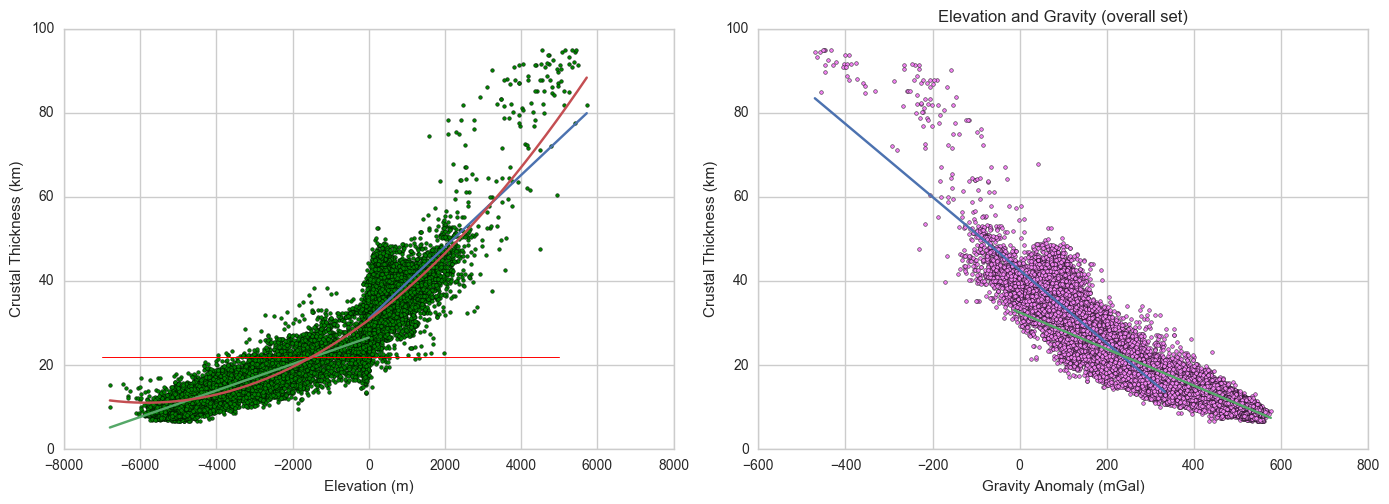

In [48]:
### overall data with regression model polyfits:

import numpy.polynomial.polynomial as poly

fig4 = plt.figure(figsize=(14,5))
with plt.style.context('seaborn-whitegrid'):
    ax4 = fig4.add_subplot(1,2,1)
    ax4.scatter(df.Elevation, df.CrustThk, s=7, c='green', label='')
    ax4.set_xlabel('Elevation (m)')
    ax4.set_ylabel('Crustal Thickness (km)')
    # adding a best fit (regression) line:
    ax4.plot(np.unique(df_dry.Elevation), np.poly1d(np.polyfit(df_dry.Elevation, df_dry.CrustThk, 1))(np.unique(df_dry.Elevation)))
    ax4.plot(np.unique(df_wet.Elevation), np.poly1d(np.polyfit(df_wet.Elevation, df_wet.CrustThk, 1))(np.unique(df_wet.Elevation)))

    ax4.plot( (-7000,5000),(22,22), lw=0.7, c='r', label='22 km thickness partition' )
        
    coefs = poly.polyfit(df.Elevation, df.CrustThk, 2)
    x_new = np.linspace(df.Elevation.min(), df.Elevation.max(), num=len(df.Elevation))
    ffit = poly.polyval(x_new, coefs)
    plt.plot(x_new, ffit)

    ax4 = fig4.add_subplot(1,2,2)
    ax4.scatter(df.Gravity, df.CrustThk, s=7, c='violet', label='')
    ax4.set_xlabel('Gravity Anomaly (mGal)')
    ax4.set_ylabel('Crustal Thickness (km)')
    # adding a best fit (regression) line:
    ax4.plot(np.unique(df_dry.Gravity), np.poly1d(np.polyfit(df_dry.Gravity, df_dry.CrustThk, 1))(np.unique(df_dry.Gravity)))
    ax4.plot(np.unique(df_wet.Gravity), np.poly1d(np.polyfit(df_wet.Gravity, df_wet.CrustThk, 1))(np.unique(df_wet.Gravity)))


    plt.tight_layout()
    plt.title('Elevation and Gravity (overall set)')
    plt.show()

__Q: Looking at the intersections of the model lines in each plot, what is the thickness of crust where they intersect?__

Here, we consider the possibility that this intersection point is in some meaningful way, indicative of the position of the OCT, or a good fit first estimate of the OCT. From here, if it is indeed so, we can refine using cluster and correlation analyses for further refinement, before moving on to worldwide sampling, then trying to train a ML model to "pluck" from the depths a good OCT for mapping purposes...or something like that.

In [39]:
# dy_ : model slope;  dx0_ : y-intersect

# for elevation:
dy_dry, dx0_dry = np.poly1d(np.polyfit(df_dry.Elevation, df_dry.CrustThk, 1))
dy_wet, dx0_wet = np.poly1d(np.polyfit(df_wet.Elevation, df_wet.CrustThk, 1))

xi = (dx0_dry-dx0_wet)/(dy_wet-dy_dry)
yi = ((dx0_wet*dy_dry)-(dy_wet*dx0_dry))/(dy_wet-dy_dry)
print('For elevation:',xi, yi)

# for gravity:
dy_dry, dx0_dry = np.poly1d(np.polyfit(df_dry.Gravity, df_dry.CrustThk, 1))
dy_wet, dx0_wet = np.poly1d(np.polyfit(df_wet.Gravity, df_wet.CrustThk, 1))

xi = (dx0_dry-dx0_wet)/(dy_wet-dy_dry)
yi = ((dx0_wet*dy_dry)-(dy_wet*dx0_dry))/(dy_wet-dy_dry)
print('For gravity:', xi, yi)

For elevation: -836.103527977 -23.9368722136
For gravity: 231.976020659 -22.4541612521


A thickness threshold of approx. 22 or 23 km for locating the OCT, as suggested by the above model intersections, may have merit, but it too may not. 

From here I see two directions to go. One would be to further partition the data and explore these smaller pieces in isolation and relative to one another. The other would be to take the sample data set and do a more sophisticated and controlled cluster analysis and then take apart the crustal thickness data in GRASS based on these and see how well those pieces fit the topography, and perhaps other data in representing the OCT. The latter seems potentially more fruitful, so...

First, run the sample data thru Fisher-Jenks:

In [49]:
# run the crustal thickness sample data:

data_array=df.ix[:,1]     # extract the crustal thickness field from the overall dataframe
num_classes=2
gvf_threshold=0.8

breaks=ComputeClusterBndys(data_array, num_classes, gvf_threshold)

print('Done')
print()
print('Natural Breaks Optimization Result:')
print(breaks)

Trying 2 class breaks...
Trying 3 class breaks...
Trying 4 class breaks...
Done

Natural Breaks Optimization Result:
[array([ 13.561388,  21.776688,  34.068588,  94.968056])]


13.6 km isn't an unreasonable first approximation to a thickness value for the OCT, but...

In [50]:
# run the submerged subset of crustal thickness sample data:

data_array=df_wet.ix[:,1]     # extract the crustal thickness field from the overall dataframe
num_classes=2
gvf_threshold=0.8

breaks=ComputeClusterBndys(data_array, num_classes, gvf_threshold)

print('Done')
print()
print('Natural Breaks Optimization Result:')
print(breaks)

Trying 2 class breaks...
Trying 3 class breaks...
Trying 4 class breaks...
Done

Natural Breaks Optimization Result:
[array([ 11.480164,  15.555084,  22.302797,  44.235935])]


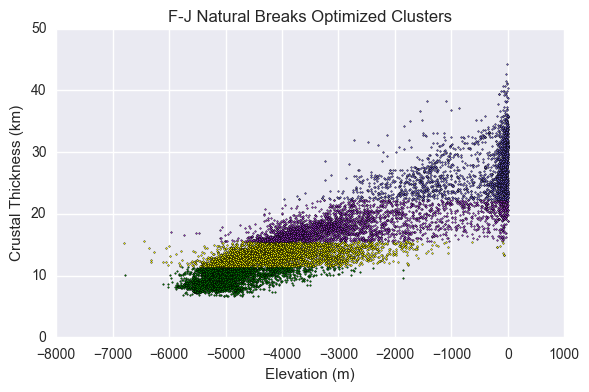

In [184]:
clrs = ['green','yellow','darkorchid','slateblue']
brks = [val for sublist in breaks for val in sublist]    #flattens the breaks list

for i, p, col in zip(range(len(brks)), brks, clrs):
    if(i == 0):
        nbc = df_wet.query('CrustThk <='+str(p))
    else:
        nbc = df_wet.query('CrustThk <='+str(brks[i])+' and '+'CrustThk >='+str(brks[i-1]))
        
    x=nbc.ix[:,1]
    y=nbc.ix[:,2]
    plt.scatter(y, x, c=col, marker='.', s=5)

plt.xlabel('Elevation (m)')
plt.ylabel('Crustal Thickness (km)')
plt.title('F-J Natural Breaks Optimized Clusters')
plt.tight_layout()
plt.show()

The first two clusters (partitioned at 11.48 m and 15.55 m) are questionable in terms of visual confirmatory evidence. The break at 22.3 m is more obvious, and not a bad first approximation for the OCT boundary.

__Mean Shift Clusters:__

Number of Clusters: 2


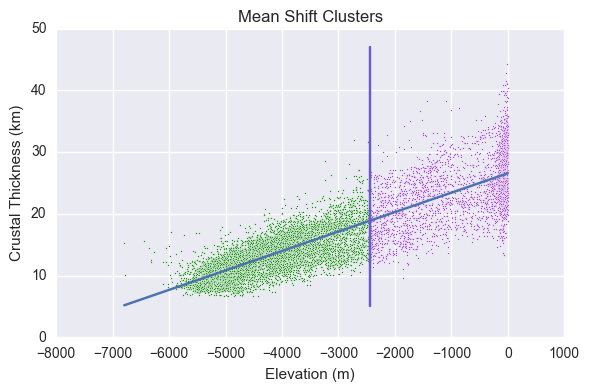

In [253]:
from sklearn.cluster import MeanShift, estimate_bandwidth

X = np.array(df_wet.ix[:,1:3])

bw = estimate_bandwidth(X)
msc = MeanShift(bw, bin_seeding=True).fit(X)
labels = msc.labels_
cluster_centers = msc.cluster_centers_

for k , col in zip(range( len(np.unique(msc.labels_)) ), ['green','darkorchid','m']):
    members = labels == k
    cluster_center = cluster_centers[k]
    plt.scatter(X[members,1], X[members, 0], c=col, marker='.', edgecolor='white', s=5)
    
# fit GLM line to df_wet data:
plt.plot(np.unique(df_wet.Elevation), np.poly1d(np.polyfit(df_wet.Elevation, df_wet.CrustThk, 1))(np.unique(df_wet.Elevation)))

# plot cluster separation line, as computered below:
plt.plot((-2442, -2442),(5,47), c='slateblue')

plt.xlabel('Elevation (m)')
plt.ylabel('Crustal Thickness (km)')
plt.title('Mean Shift Clusters')
plt.tight_layout()
print('Number of Clusters:', len(cluster_centers))
plt.show()

The break between the two clusters estimated by Mean Shift do present pretty good visual evidence to support and validate. It is, however, more difficult to interpret and extract a useful boundary to convey to the crustal thickness and/or elevation data as a representative OCT. There does, on the other hand, appear to be a distinct vertical boundary separating the two clusters. Perhaps this boundary, coupled with the GLM line fit already overprinted on the plot, above, can suggest a representative first-approximation for the OCT?

In [250]:
# locate the vertical boundary that seems to divide the two Mean Shift defined clusters:

X_0=[];  X_1=[]
for x, l in zip(X, labels):
    if(l == 0):
        X_0.append(x)
    if(l == 1):
        X_1.append(x)
        
X_0 = np.array(X_0)
X_1 = np.array(X_1)

print('For cluster 0:',X_0[:,1].max())
print('For cluster 1:',X_1[:,1].min())

For cluster 0: -2443.0
For cluster 1: -2441.0


In [256]:
# Compute the intersection of the GLM model and cluster boundary lines in the Mean Shift Cluster model plot, above:

# compute the slope and intercept for the GLM line:
slope, yintercept = np.poly1d(np.polyfit(df_wet.Elevation, df_wet.CrustThk, 1))

xi = -2442
yi = slope*xi + yintercept
print('Lines intersect at:',xi, yi)

Lines intersect at: -2442 18.883852448


Perhaps for reasons that the Mean Shift clusters have more visual support (see the plot, above) for the estimated boundaries, I'm a bit more confident of the mean shift result (OCT estimate at 18.9 km) versus that provided by Natural Breaks--although the two actually agree surprisingly well (the latter show breaks at 15.6 and 22.3 km, which bookend the mean shift result). Data should always be so 'friendly' and 'well-behaved'. Or, have I missed something?

As a first approximation and estimate (to test): <br>
crust < 18.9 km is classed as oceanic <br>
crust > 18.9 km is classed as continental 

Let's go to GRASS and find out...

__DBSCAN Clusters:__

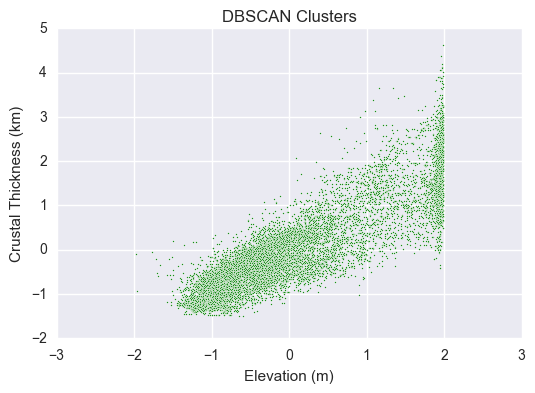

In [196]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform( np.array(df_wet.ix[:,1:3]) )

dbc = DBSCAN(eps=10, min_samples=10).fit(X)
labels = dbc.labels_

for k , col in zip(np.unique(labels), ['green','darkorchid']):
    members = labels == k
    plt.scatter(X[members,1], X[members, 0], c=col, marker='.', edgecolor='white', s=5)
    
plt.xlabel('Elevation (m)')
plt.ylabel('Crustal Thickness (km)')
plt.title('DBSCAN Clusters')
plt.show()

DBSCAN was unable to discriminate what is pretty clearly an anisotropic distribution (density) of data points and so isn't useful. Perhaps if the interface was a bit stronger between the higher-density region in the lower left of the cloud versus that in the upper right we could get separation, and thus something to compare and contrast against the N-B and Mean Shift methods and results...

Continued on notebook: _CMM Sample Data (20k pnts) Crustal Thickness Analysis III_